In [1]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
'''
    python ==> 소프트웨어융합최신기술 part3_2, 신호등 사진을 주면 색깔을 맞혀보는 프로젝트
                                               정확도 & 시간을 둘 다 고려해서 모델을 맞춰야 한다

                                               2 CNN & 2 Max pooling layer (2 SAME)
                                               1 fully connected layer
                                               drop out
'''
#5
%matplotlib inline

import sys, os, time
import itertools
import math, random
import glob
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Basic parameters
max_epochs = 25
base_image_path = "5_tensorflow_traffic_light_images/"
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
batch_size = 32
checkpoint_name = "./model.ckpt"


In [3]:
# Helper layer functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [4]:
# Model
x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])

In [5]:
# Model - THIS PART SHOULD BE SAVED SEPARATELY IN "model.txt" file, SO IT CAN BE RETRIEVED AUTOMATICALLY BY "ranking.ipynb"
#  꼭 model.txt 파일을 사용해야하고 이름을 바꾸면 안된다!
#  이곳에 있는 코드를 model.txt에 넣은 다음 test 코드에서 불러와서 execute(contents)를 해서 아래 코드를 실행시킨다 굳굳
#START-------------------------------------------------------------------------
# 2 CNN & 2 Max pooling layer (2 SAME)
# 1 fully connected layer
# drop out
def conv2d_valid(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

# if you can type '/gpu:0' or '/cpu:0'
with tf.device('/cpu:0'):
    x_image = x

    # 1st conv layer-----------------------------
    W_conv1 = weight_variable([3, 3, 3, 16])
    b_conv1 = bias_variable([16])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) # (32,32) ==> (16,16)


    # 2nd conv layer-----------------------------
    W_conv2 = weight_variable([5,5,16,32])
    b_conv2 = weight_variable([32]) 

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 1) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2) # (16,16) ==> (8,8)


    # 1st Fully Connected layer------------------------
    n1, n2, n3, n4 = h_pool2.get_shape().as_list()

    W_fc1 = weight_variable([n2*n3*n4, 3])
    b_fc1 = bias_variable([3])

    h_pool1_flat = tf.reshape(h_pool2, [-1, n2*n3*n4]) 

    y= tf.matmul(h_pool1_flat, W_fc1) + b_fc1 # (4,4) ==> (3,1)

    # Our loss function and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))
    train_step = tf.train.AdamOptimizer(1e-4, 0.9).minimize(loss)
#END-------------------------------------------------------------------------


saver = tf.train.Saver({'W_conv1' : W_conv1, 'b_conv1' : b_conv1, 'W_conv2' : W_conv2,'b_conv2' : b_conv2,  'W_fc1' : W_fc1, 'b_fc1' : b_fc1})

In [6]:
# Our loss function and optimizer
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
v_loss = least_loss = 99999999

# Load data
full_set = []

# base_image_path에서 모든 이미지 데이터를 읽어온다
for im_type in image_types:
    for ex in glob.glob(os.path.join(base_image_path, im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            # 모든 이미지를 32x32로 리사이징한다
            im = cv2.resize(im, (32, 32))

            # one hot vector를 만든다 
            # Create an array representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1

            assert(im.shape == (32, 32, 3))

            full_set.append((im, one_hot_array, ex))

#  모든 데이터를 받아서 랜덤으로 섞는다 
random.shuffle(full_set)



In [8]:
# Train set, Test set을 나누는 코드 (9:1)
# We split our data into a training and test set here
split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)


In [11]:
print("Starting training... [{} training examples]".format(len(train_x)))
v_loss = 9999999
train_loss = []
val_loss = []


for i in range(0, max_epochs):
    # Iterate over our training set
    for tt in range(0, (len(train_x) // batch_size)):
        start_batch = batch_size * tt
        end_batch = batch_size * (tt + 1)
        train_step.run(feed_dict={x: train_x[start_batch:end_batch], y_: train_y[start_batch:end_batch]})
        #ex_seen = "Current epoch, examples seen: {:20} / {} \r\n".format(tt * batch_size, len(train_x))
        #sys.stdout.write(ex_seen.format(tt * batch_size))
        #sys.stdout.flush()

    #ex_seen = "Current epoch, examples seen: {:20} / {} \r\n".format((tt + 1) * batch_size, len(train_x))
    #sys.stdout.write(ex_seen.format(tt * batch_size))
    #sys.stdout.flush()

    t_loss = loss.eval(feed_dict={x: train_x, y_: train_y})
    v_loss = loss.eval(feed_dict={x: test_x, y_: test_y})
    
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val. loss: {:15.10f}".format(i + 1, t_loss, v_loss))

    #  v_loss가 제일 낮을 경우에만 파라미터를 저장한다
    if v_loss < least_loss:
        sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
        least_loss = v_loss
        filename = saver.save(sess, checkpoint_name)

    sys.stdout.write("\n")


Starting training... [1312 training examples]
Epoch     1: loss:    0.1140425131, val. loss:    0.5875147581, saving new best model to ./model.ckpt
Epoch     2: loss:    0.3003812134, val. loss:    0.7594460249
Epoch     3: loss:    0.2462198138, val. loss:    0.7016215324
Epoch     4: loss:    0.0514584295, val. loss:    0.5475843549, saving new best model to ./model.ckpt
Epoch     5: loss:    0.2683818042, val. loss:    0.6724276543
Epoch     6: loss:    0.3689961731, val. loss:    0.8223484755
Epoch     7: loss:    0.3428547084, val. loss:    0.7536970973
Epoch     8: loss:    0.0316327214, val. loss:    0.5524554849
Epoch     9: loss:    0.0558923297, val. loss:    0.5435688496, saving new best model to ./model.ckpt
Epoch    10: loss:    0.0750845596, val. loss:    0.5603680611
Epoch    11: loss:    0.2901585400, val. loss:    0.6923329830
Epoch    12: loss:    0.1377433985, val. loss:    0.6181033850
Epoch    13: loss:    0.0308018420, val. loss:    0.5057134032, saving new best m

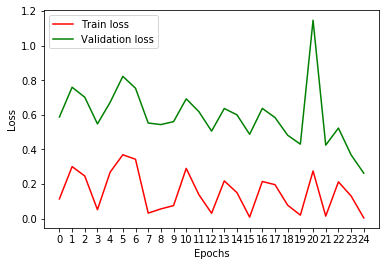

In [17]:
# ed: 윗부분까지가 사실상 끝난 것이다. 아랫부분은 analyze 부분

plt.figure()
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Let's print the examples from our test set that were wrong:

Actual: yellow, predicted: red


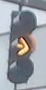

Actual: red, predicted: green


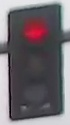

In [18]:
zipped_x_y = list(zip(test_x, test_y))
conf_true = []
conf_pred = []
for tt in range(0, len(zipped_x_y)):
    q = zipped_x_y[tt]
    sfmax = list(sess.run(tf.nn.softmax(y.eval(feed_dict={x: [q[0]]})))[0])
    sf_ind = sfmax.index(max(sfmax))
    
    predicted_label = image_types[sf_ind]
    actual_label = image_types[q[1].index(max(q[1]))]
    
    conf_true.append(actual_label)
    conf_pred.append(predicted_label)
    
    if predicted_label != actual_label:
        print("Actual: {}, predicted: {}".format(actual_label, predicted_label))
        img_path = test_z[tt]    
        ex_img = Image(filename=img_path)
        display(ex_img)

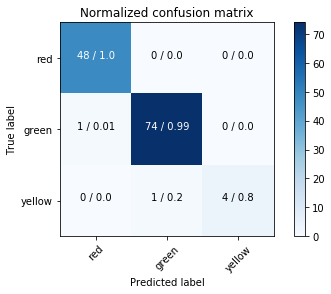

In [19]:
# From sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm2 = np.around(cm2, 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + " / " + str(cm2[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(conf_true, conf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=image_types, normalize=False,
                      title='Normalized confusion matrix')
plt.show()